Copyright (c) 2020 Ryan Cohn and Elizabeth Holm. All rights reserved. <br />
Licensed under the MIT License (see LICENSE for details) <br />
Written by Ryan Cohn

# Instance Segmentation of Powder Particles and Satellites

This example will take you through the process of training a model to segment powder particles and visualizing the model predictions.

In [1]:
## regular module imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import skimage.io
import sys

## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode

root = '../../../'
ocean_images = root + '../../../../ocean/projects/dmr200021p/sprice/initial_paper_complete_set/'
ocean_syn = root + '../../../../ocean/projects/dmr200021p/sprice/synthetic_training/'
sys.path.append(root)

from ampis import data_utils, visualize, export_anno

%matplotlib inline

# Labeling Data

The [VGG Image Annotator](http://www.robots.ox.ac.uk/~vgg/software/via/) was used to generate particle labels. The a

# Loading Data
The process for training models for powder particles and satellites is identical. Enter the corresponding value depending on which model you want to train. <br />
The paths to individual images, and all annotation data are stored in the JSON files generated by the VGG image annotator.



In [2]:
EXPERIMENT_NAME = 'satellite' # can be 'particle' or 'satellite'
json_path_train = Path(ocean_syn,'trainings','synthetic_training_satellite_a1.2.json')  # path to training data
json_path_val = Path(ocean_syn,'trainings', 'synthetic_validation_satellite_a1.0.json')  # path to training data
assert json_path_train.is_file(), 'training file not found!'
assert json_path_val.is_file(), 'validation file not found!'


## Registration
Detectron2 requires that datasets be registered for later use.
Registration stores the name of the dataset and a function that can be used to retrieve the image paths and labels in a format that the model can use.

In [3]:
DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times

# store names of datasets that will be registered for easier access later
dataset_train = f'{EXPERIMENT_NAME}_Train'
dataset_valid = f'{EXPERIMENT_NAME}_Val'

# register the training dataset
DatasetCatalog.register(dataset_train, lambda f = json_path_train: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                     im_root=f,  # path to the training data json file
                                                                                                     dataset_class='Train'))  # indicates this is training data
# register the validation dataset
DatasetCatalog.register(dataset_valid, lambda f = json_path_val: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                im_root=f,  # path to validation data json file
                                                                                                dataset_class='Validation'))  # indicates this is validation data
                              
print(f'Registered Datasets: {DatasetCatalog.list()}')

## There is also a metadata catalog, which stores the class names.
for d in [dataset_train, dataset_valid]:
    MetadataCatalog.get(d).set(**{'thing_classes': [EXPERIMENT_NAME]})

Registered Datasets: ['satellite_Train', 'satellite_Val']


## Verify images and annotations are loaded correctly
Also, this is a great time to admire my hand-drawn labels, which took sooooo long to do!
### Training Data

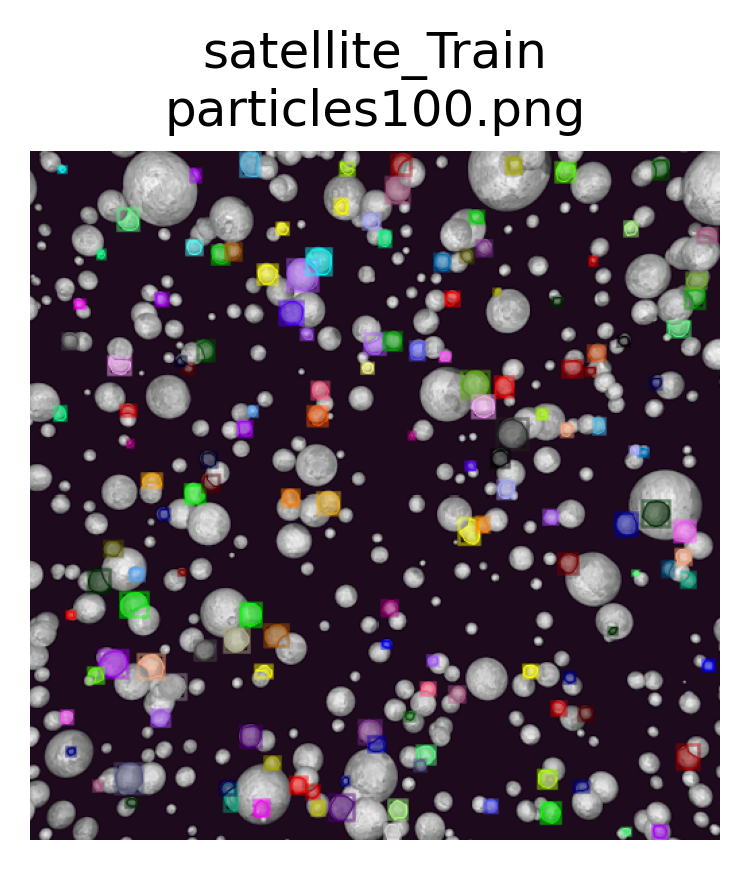

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles100.png
	num_instances: 148


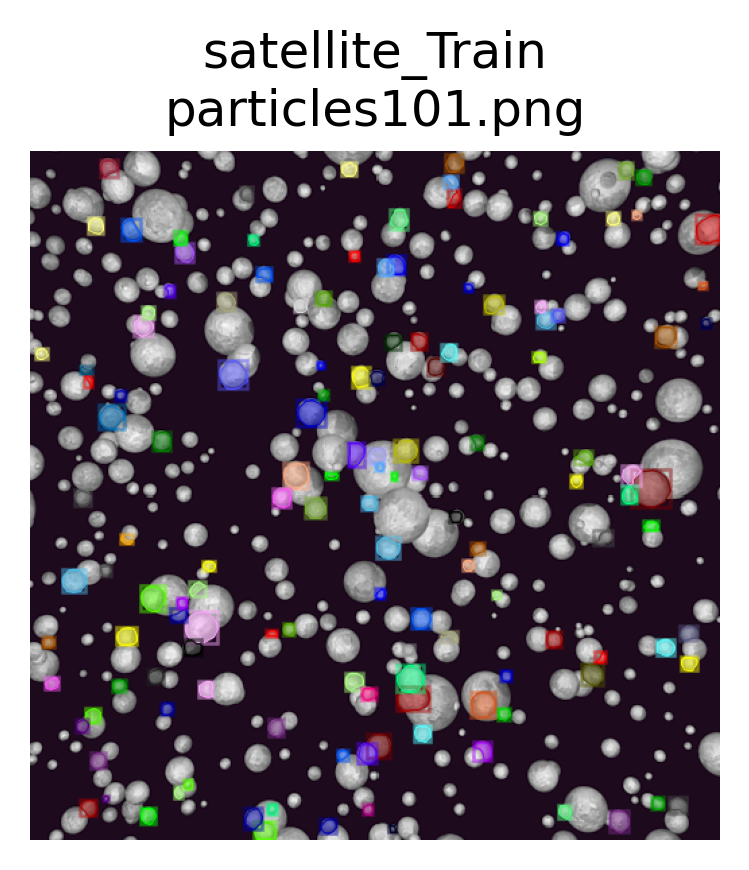

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles101.png
	num_instances: 139


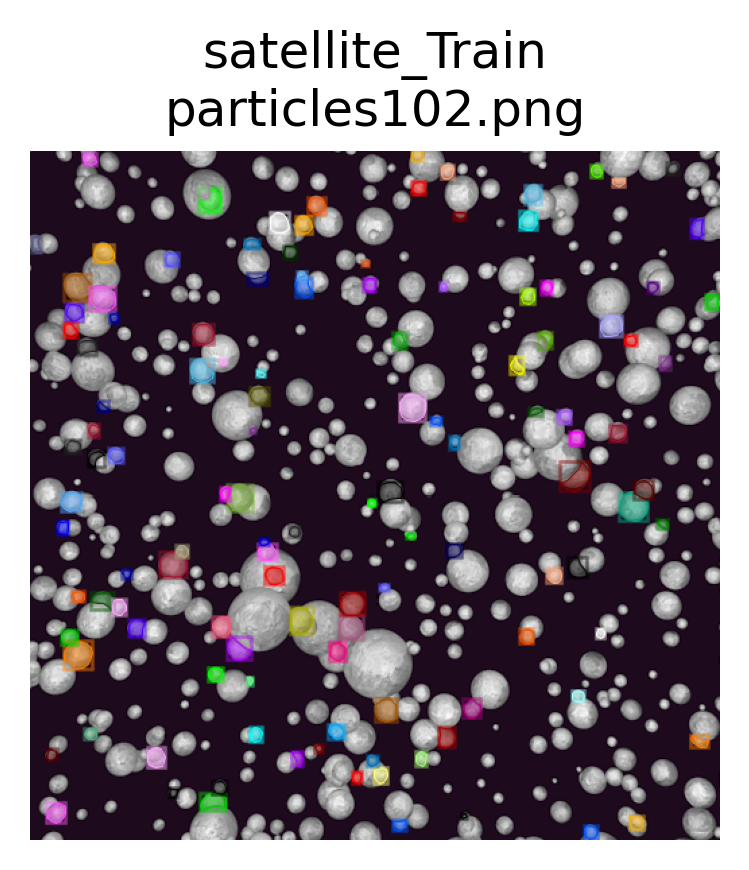

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles102.png
	num_instances: 123


In [4]:
#for i in np.random.choice(DatasetCatalog.get(dataset_train), 3, replace=False):
    #visualize.display_ddicts(i, None, dataset_train, suppress_labels=True)
for i in DatasetCatalog.get(dataset_train):
    visualize.display_ddicts(i, None, dataset_train, suppress_labels=True)

### Validation Data

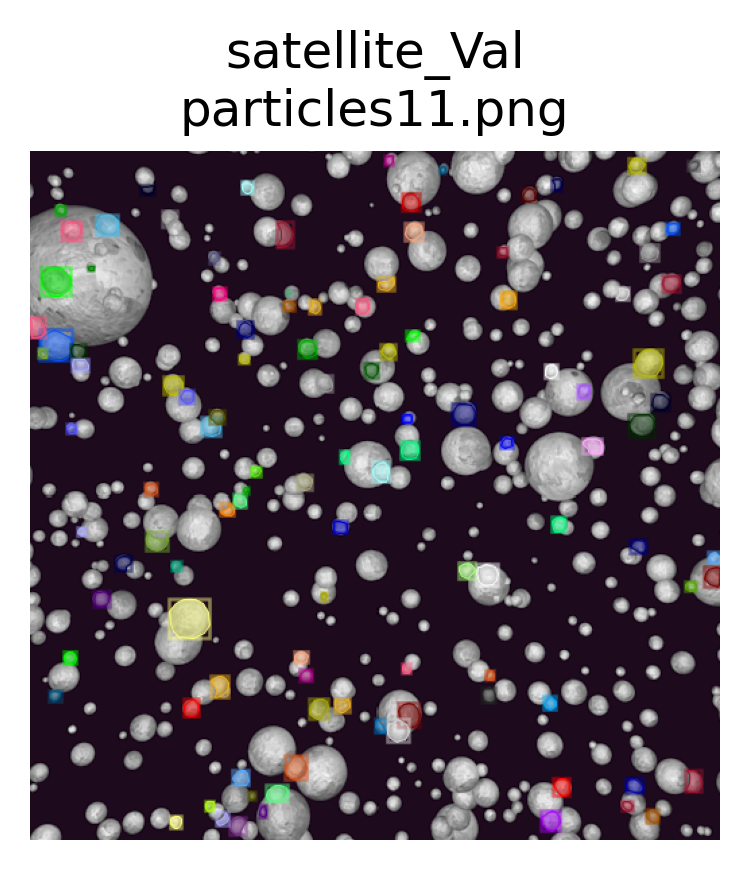

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles11.png
	num_instances: 110


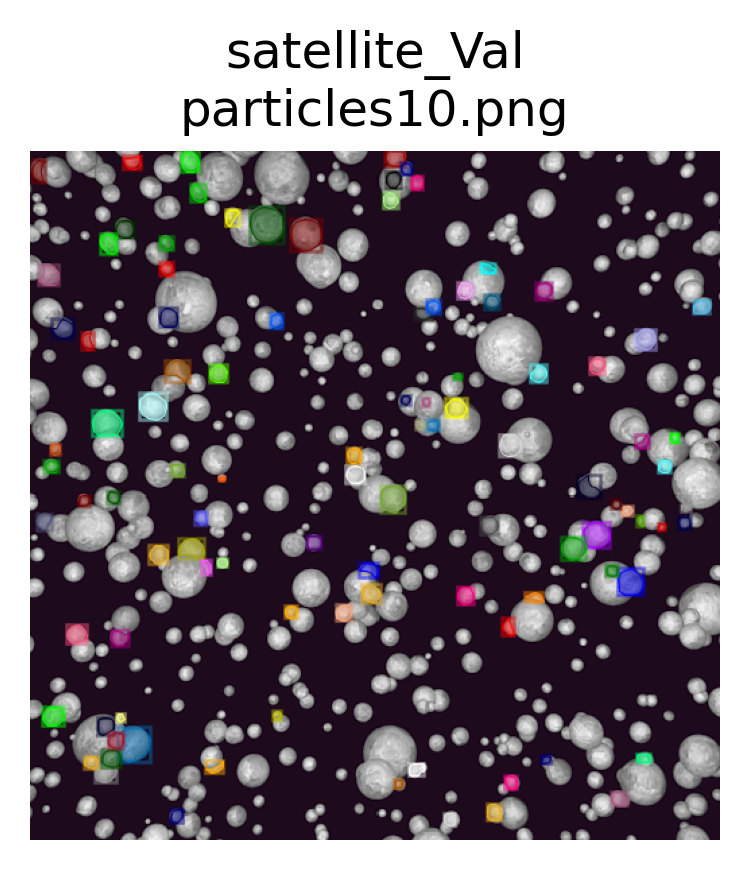

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles10.png
	num_instances: 101


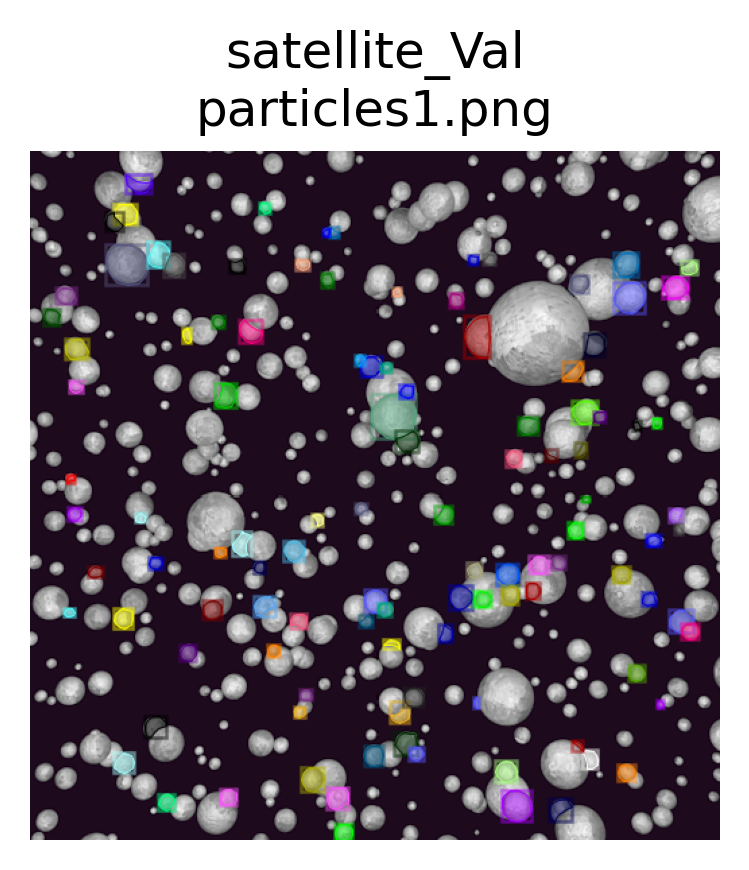

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles1.png
	num_instances: 110


In [5]:
for i in DatasetCatalog.get(dataset_valid):
    visualize.display_ddicts(i, None, dataset_valid, suppress_labels=True)

## Model Configuration
This is where we specify the directory where the outputs are saved, various hyperparameters for the model, and more.

In [6]:
cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
cfg.DATASETS.TRAIN = (dataset_train,)  # dataset used for training model
cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # we will look at the predictions on both sets after training
cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 250  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.SOLVER.MAX_ITER = 15000  # maximum number of iterations to run during training
                            # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)

# model weights will be downloaded if they are not present
weights_path = Path('..','..','models','model_final_f10217.pkl')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)
cfg.OUTPUT_DIR = str(Path(ocean_syn,'Models', 'Synthetic_training_a1.2'))
# make the output directory
os.makedirs(Path(cfg.OUTPUT_DIR), exist_ok=True)

Weights not found, weights will be downloaded from source: https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl


# Model Training
Once we have everything set up, training is very easy!

Note- this block will generate a huge wall of text.

In [ ]:
trainer = DefaultTrainer(cfg)  # create trainer object from cfg
trainer.resume_or_load(resume=False)  # start training from iteration 0
trainer.train()  # train the model!

[07/27 14:45:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[07/27 14:45:39 d2.data.build]: Removed 0 images with no usable annotations. 3 images left.
[07/27 14:45:39 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| satellite  | 410          |
|            |              |
[07/27 14:45:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/27 14:45:39 d2.data.build]: Using training sampler TrainingSampler
[07/27 14:45:39 d2.data.common]: Serializing 3 elements to byte tensors and concatenating them all ...
[07/27 14:45:39 d2.data.common]: Serialized dataset takes 0.11 MiB
WARNING [07/27 14:45:39 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


/jet/home/sprice/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[07/27 14:45:40 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[07/27 14:45:40 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*  

[07/27 14:46:12 d2.utils.events]:  eta: 0:32:47  iter: 219  total_loss: 1.579  loss_cls: 0.233  loss_box_reg: 0.3998  loss_mask: 0.3288  loss_rpn_cls: 0.2705  loss_rpn_loc: 0.3256  time: 0.1368  data_time: 0.0141  lr: 0.0043956  max_mem: 1551M
[07/27 14:46:15 d2.utils.events]:  eta: 0:32:51  iter: 239  total_loss: 1.52  loss_cls: 0.2003  loss_box_reg: 0.3839  loss_mask: 0.3618  loss_rpn_cls: 0.2491  loss_rpn_loc: 0.3316  time: 0.1367  data_time: 0.0128  lr: 0.0047952  max_mem: 1551M
[07/27 14:46:18 d2.utils.events]:  eta: 0:32:46  iter: 259  total_loss: 1.505  loss_cls: 0.2137  loss_box_reg: 0.3659  loss_mask: 0.3279  loss_rpn_cls: 0.2538  loss_rpn_loc: 0.3485  time: 0.1365  data_time: 0.0136  lr: 0.0051948  max_mem: 1551M
[07/27 14:46:21 d2.utils.events]:  eta: 0:32:39  iter: 279  total_loss: 1.427  loss_cls: 0.2077  loss_box_reg: 0.3733  loss_mask: 0.3008  loss_rpn_cls: 0.2333  loss_rpn_loc: 0.3113  time: 0.1363  data_time: 0.0120  lr: 0.0055944  max_mem: 1551M
[07/27 14:46:23 d2.uti

[07/27 14:47:42 d2.utils.events]:  eta: 0:31:08  iter: 879  total_loss: 1.046  loss_cls: 0.1275  loss_box_reg: 0.2834  loss_mask: 0.2094  loss_rpn_cls: 0.1119  loss_rpn_loc: 0.2756  time: 0.1344  data_time: 0.0113  lr: 0.017582  max_mem: 1551M
[07/27 14:47:45 d2.utils.events]:  eta: 0:31:06  iter: 899  total_loss: 1.035  loss_cls: 0.1305  loss_box_reg: 0.2893  loss_mask: 0.2074  loss_rpn_cls: 0.1311  loss_rpn_loc: 0.2781  time: 0.1344  data_time: 0.0102  lr: 0.017982  max_mem: 1551M
[07/27 14:47:48 d2.utils.events]:  eta: 0:31:03  iter: 919  total_loss: 1.066  loss_cls: 0.1379  loss_box_reg: 0.298  loss_mask: 0.196  loss_rpn_cls: 0.1496  loss_rpn_loc: 0.286  time: 0.1343  data_time: 0.0113  lr: 0.018382  max_mem: 1551M
[07/27 14:47:50 d2.utils.events]:  eta: 0:31:00  iter: 939  total_loss: 1.034  loss_cls: 0.1215  loss_box_reg: 0.2595  loss_mask: 0.1891  loss_rpn_cls: 0.1389  loss_rpn_loc: 0.3086  time: 0.1343  data_time: 0.0148  lr: 0.018781  max_mem: 1551M
[07/27 14:47:53 d2.utils.ev

[07/27 14:49:12 d2.utils.events]:  eta: 0:29:30  iter: 1539  total_loss: 0.834  loss_cls: 0.1082  loss_box_reg: 0.2344  loss_mask: 0.1412  loss_rpn_cls: 0.09353  loss_rpn_loc: 0.249  time: 0.1336  data_time: 0.0140  lr: 0.02  max_mem: 1551M
[07/27 14:49:15 d2.utils.events]:  eta: 0:29:28  iter: 1559  total_loss: 0.8022  loss_cls: 0.09954  loss_box_reg: 0.2328  loss_mask: 0.1426  loss_rpn_cls: 0.08267  loss_rpn_loc: 0.2358  time: 0.1336  data_time: 0.0146  lr: 0.02  max_mem: 1551M
[07/27 14:49:17 d2.utils.events]:  eta: 0:29:24  iter: 1579  total_loss: 0.7796  loss_cls: 0.09398  loss_box_reg: 0.2315  loss_mask: 0.1398  loss_rpn_cls: 0.09257  loss_rpn_loc: 0.2174  time: 0.1336  data_time: 0.0153  lr: 0.02  max_mem: 1551M
[07/27 14:49:20 d2.utils.events]:  eta: 0:29:20  iter: 1599  total_loss: 0.766  loss_cls: 0.0972  loss_box_reg: 0.2199  loss_mask: 0.1323  loss_rpn_cls: 0.07044  loss_rpn_loc: 0.2484  time: 0.1336  data_time: 0.0136  lr: 0.02  max_mem: 1551M
[07/27 14:49:23 d2.utils.even

[07/27 14:50:41 d2.utils.events]:  eta: 0:27:58  iter: 2199  total_loss: 0.6327  loss_cls: 0.07629  loss_box_reg: 0.185  loss_mask: 0.1136  loss_rpn_cls: 0.05612  loss_rpn_loc: 0.1992  time: 0.1330  data_time: 0.0150  lr: 0.02  max_mem: 1551M
[07/27 14:50:44 d2.utils.events]:  eta: 0:27:55  iter: 2219  total_loss: 0.6195  loss_cls: 0.07033  loss_box_reg: 0.1927  loss_mask: 0.1159  loss_rpn_cls: 0.05124  loss_rpn_loc: 0.1952  time: 0.1330  data_time: 0.0144  lr: 0.02  max_mem: 1551M
[07/27 14:50:47 d2.utils.events]:  eta: 0:27:53  iter: 2239  total_loss: 0.6454  loss_cls: 0.08355  loss_box_reg: 0.1852  loss_mask: 0.1095  loss_rpn_cls: 0.055  loss_rpn_loc: 0.2048  time: 0.1330  data_time: 0.0147  lr: 0.02  max_mem: 1551M
[07/27 14:50:49 d2.utils.events]:  eta: 0:27:51  iter: 2259  total_loss: 0.6368  loss_cls: 0.07548  loss_box_reg: 0.1795  loss_mask: 0.1079  loss_rpn_cls: 0.06093  loss_rpn_loc: 0.2033  time: 0.1331  data_time: 0.0145  lr: 0.02  max_mem: 1551M
[07/27 14:50:52 d2.utils.ev

[07/27 14:52:11 d2.utils.events]:  eta: 0:26:35  iter: 2859  total_loss: 0.571  loss_cls: 0.06163  loss_box_reg: 0.1599  loss_mask: 0.09585  loss_rpn_cls: 0.05634  loss_rpn_loc: 0.184  time: 0.1330  data_time: 0.0147  lr: 0.02  max_mem: 1551M
[07/27 14:52:13 d2.utils.events]:  eta: 0:26:33  iter: 2879  total_loss: 0.5705  loss_cls: 0.0666  loss_box_reg: 0.1643  loss_mask: 0.0969  loss_rpn_cls: 0.05431  loss_rpn_loc: 0.1976  time: 0.1330  data_time: 0.0131  lr: 0.02  max_mem: 1551M
[07/27 14:52:16 d2.utils.events]:  eta: 0:26:30  iter: 2899  total_loss: 0.5389  loss_cls: 0.06502  loss_box_reg: 0.1632  loss_mask: 0.1011  loss_rpn_cls: 0.03383  loss_rpn_loc: 0.1704  time: 0.1330  data_time: 0.0139  lr: 0.02  max_mem: 1551M
[07/27 14:52:19 d2.utils.events]:  eta: 0:26:28  iter: 2919  total_loss: 0.5217  loss_cls: 0.05445  loss_box_reg: 0.1597  loss_mask: 0.09219  loss_rpn_cls: 0.04771  loss_rpn_loc: 0.166  time: 0.1330  data_time: 0.0132  lr: 0.02  max_mem: 1551M
[07/27 14:52:21 d2.utils.e

# Visualizing model predictions
We will view the model predictions on the training and validation set.

In [9]:
model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
#cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # predictor requires this field to not be empty
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
predictor = DefaultPredictor(cfg)  # create predictor object

Dataset: satellite_Train
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles100.png


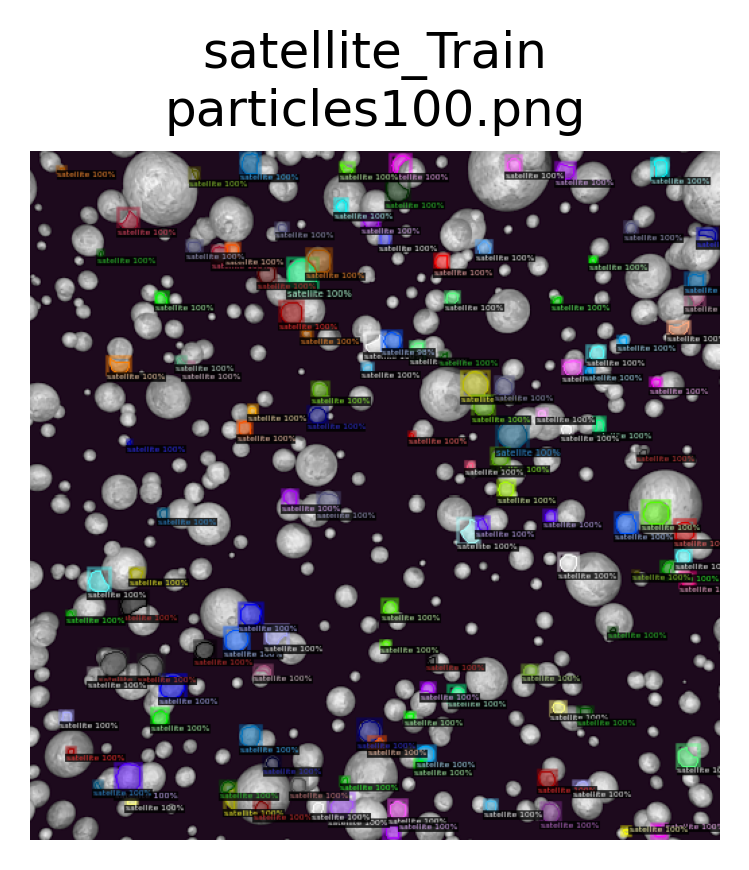

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles100.png
	num_instances: 129
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles101.png


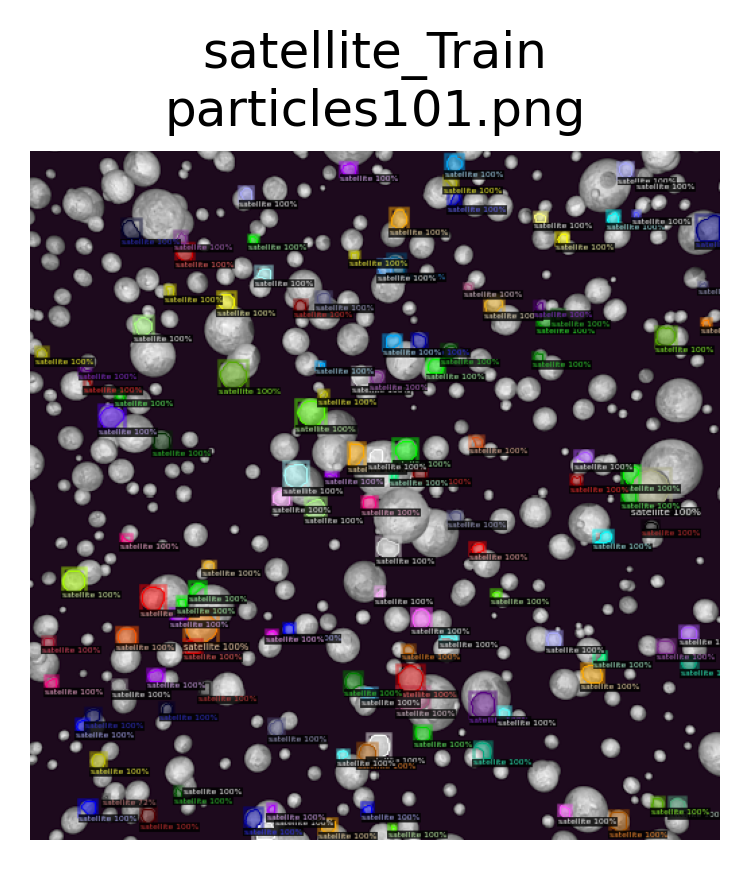

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles101.png
	num_instances: 131
Dataset: satellite_Val
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles11.png


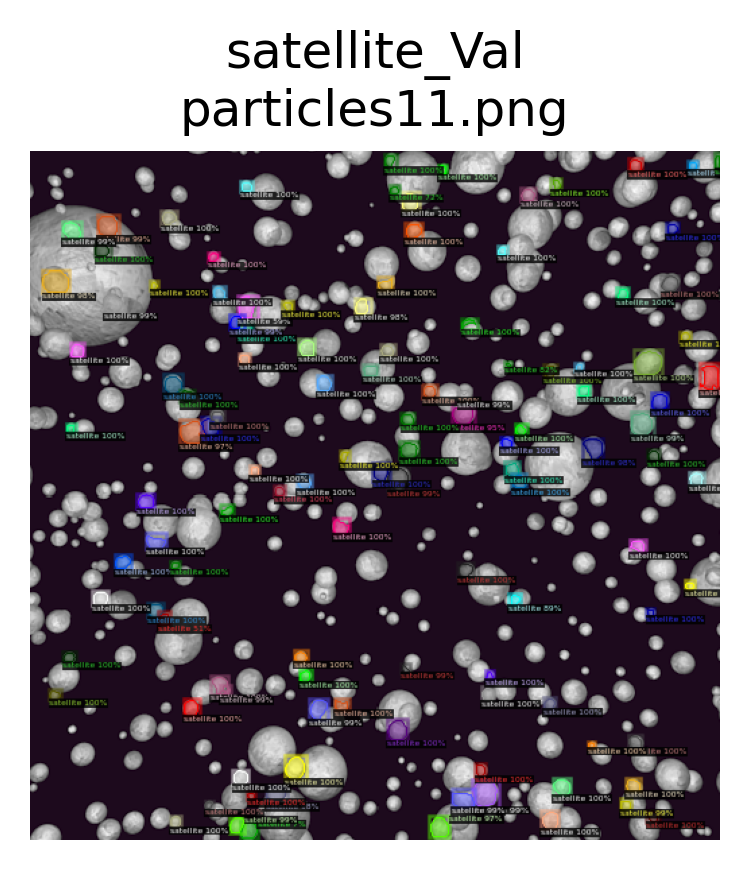

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles11.png
	num_instances: 117
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles10.png


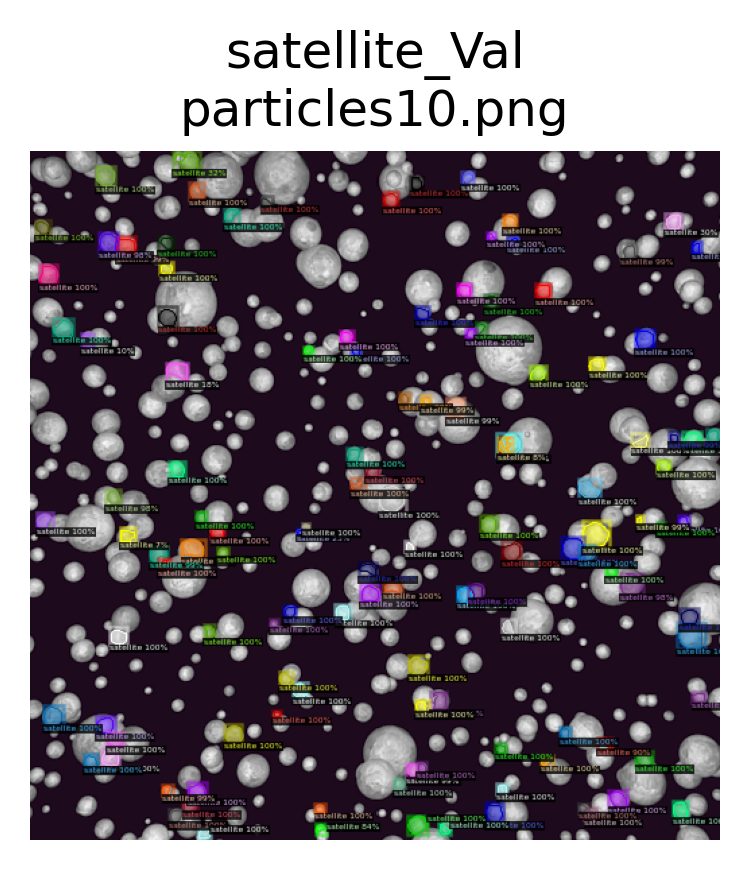

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles10.png
	num_instances: 123
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles1.png


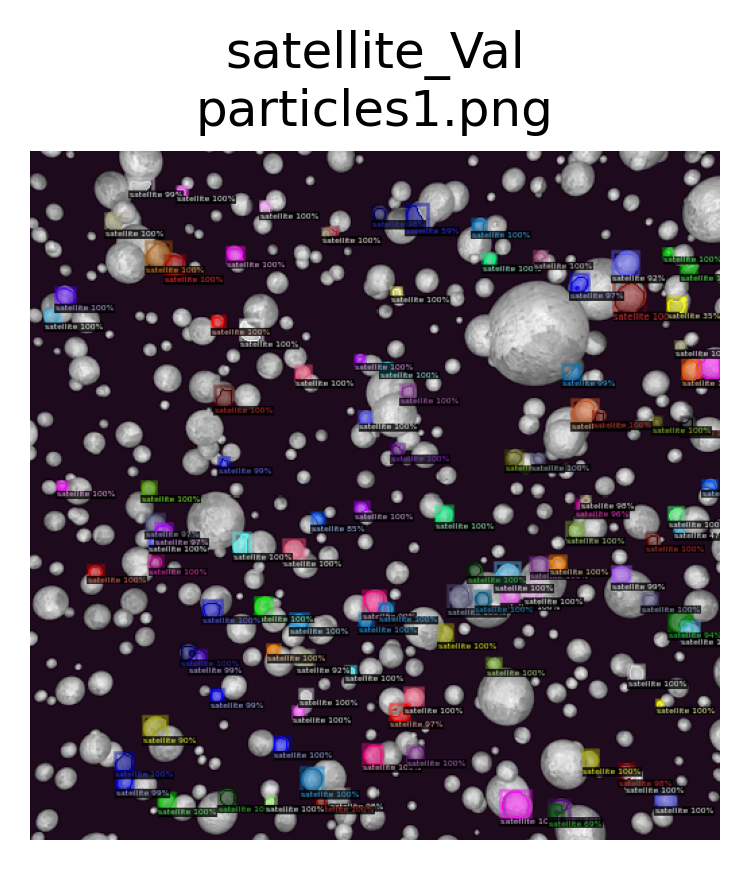

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles1.png
	num_instances: 113


In [10]:
results = []
for ds in cfg.DATASETS.TEST:
    print(f'Dataset: {ds}')
    for dd in DatasetCatalog.get(ds):
        print(f'\tFile: {dd["file_name"]}')
        img = cv2.imread(dd['file_name'])  # load image
        outs = predictor(img)  # run inference on image
        
        # format results for visualization and store for later
        results.append(data_utils.format_outputs(dd['file_name'], ds, outs))

        # visualize results
        visualize.display_ddicts(outs, None, ds, gt=False, img_path=dd['file_name'])

# save to disk
#with open(Path('Stage_results',f'{EXPERIMENT_NAME}-base_stage.pickle'), 'wb') as f:
#    pickle.dump(results, f)

## Generating predictions on new images is simple.
We will load a new image (not included in either dataset) and generate predictions.
Note that we do not have labels for this image and do not need to register it to a dataset.

In [9]:
img_path = Path('..', 'Auto_annotate_images','S01_02_SE1_300X06.png')
img = cv2.imread(str(img_path))
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save figure
                                 gt=False,  # specifies format as model predictions
                                img_path=img_path)  # path to image


AttributeError: 'NoneType' object has no attribute 'shape'

In [13]:
path = ocean_syn + 'images/a-lognormal-loc0.1-shape0.5/renders'
files = os.listdir(path)
img_names = []
for f in files:
    if f.split('.')[0] != 'particles103' and f.split('.')[0] != 'particles129' and f.split('.')[0] != 'particles159' and f.split('.')[0] != 'particles180':
        img_names.append(f.split('.')[0])
'''for f in img_names:
    print("Annotating: " + f)
    img_path = Path('..', 'data','images_png', f +'.png')
    img = cv2.imread(str(img_path))
    outs = predictor(img)
    export1 = export_anno.make_VIA_file(f +'.png', img_path, outs)
    export_anno.save_to_json(str(ampis_root) + f'/pred_annos/{EXPERIMENT_NAME}/' + f +'_anno.json', export1)
    outs = predictor(img)
    data_utils.format_outputs(img_path, dataset='test', pred=outs)
    visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                summary=False)  #hides the end print statement'''    
img_names.sort()
print(img_names)
for f in img_names:
    if len(f) > 9:
        print("Annotating: " + f)
        img_path = Path(path, f +'.png')
        img = cv2.imread(str(img_path))
        outs = predictor(img)
        #export1 = export_anno.make_VIA_file(f +'.png', img_path, outs)
        #export_anno.save_to_json(ocean_syn + 'pred_annos/a-lognormal-loc0.1-shape0.5/stage1.2/' + f +'_anno.json', export1)
        outs = predictor(img)
        data_utils.format_outputs(img_path, dataset='test', pred=outs)
        '''visualize.display_ddicts(ddict=outs,  # predictions to display
                                     outpath=None, dataset='Test',  # don't save fi$
                                     gt=False,  # specifies format as model predict$
                                     img_path=img_path, # path to image
                                     suppress_labels=True, #hides class images
                                     summary=True)  #hides the end print statement'''

['particles1', 'particles10', 'particles100', 'particles101', 'particles102', 'particles104', 'particles105', 'particles106', 'particles107', 'particles108', 'particles109', 'particles11', 'particles110', 'particles111', 'particles112', 'particles113', 'particles114', 'particles115', 'particles116', 'particles117', 'particles118', 'particles119', 'particles12', 'particles120', 'particles121', 'particles122', 'particles123', 'particles124', 'particles125', 'particles126', 'particles127', 'particles128', 'particles13', 'particles130', 'particles131', 'particles132', 'particles133', 'particles134', 'particles135', 'particles136', 'particles137', 'particles138', 'particles139', 'particles14', 'particles140', 'particles141', 'particles142', 'particles143', 'particles144', 'particles145', 'particles146', 'particles147', 'particles148', 'particles149', 'particles15', 'particles150', 'particles151', 'particles152', 'particles153', 'particles154', 'particles155', 'particles156', 'particles157',

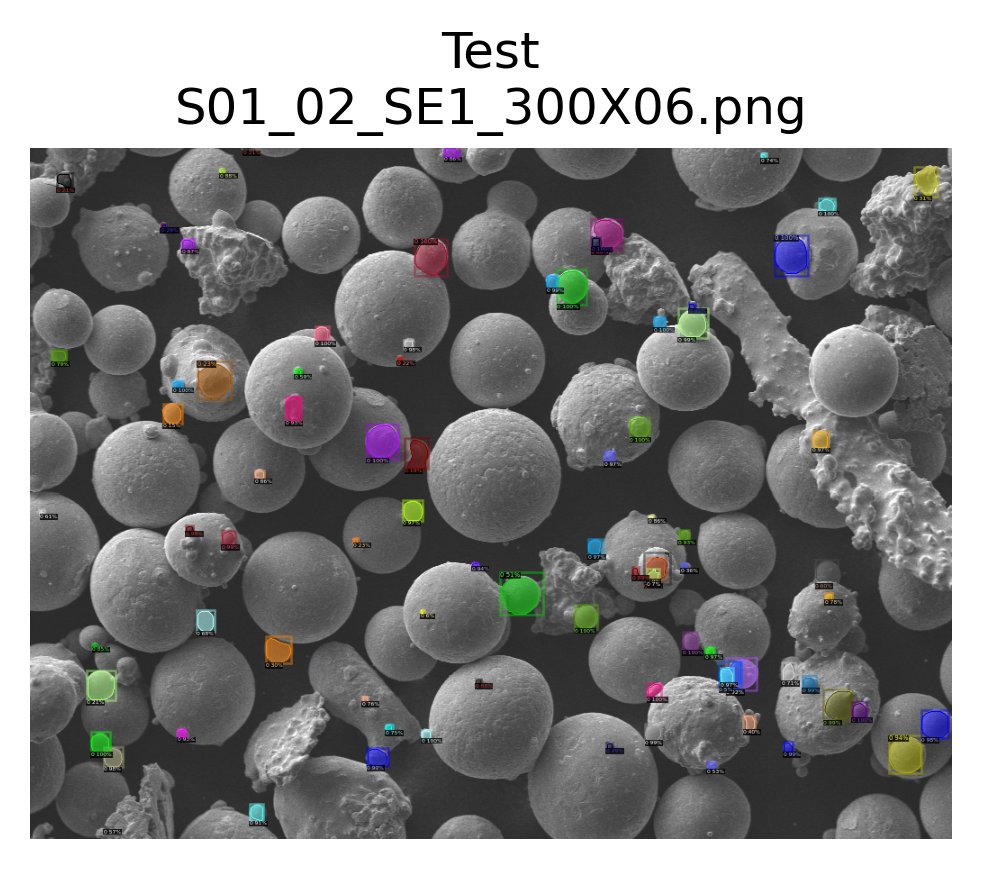

ddict info:
	path: ../Auto_annotate_images/S01_02_SE1_300X06.png
	num_instances: 84


In [11]:
img_path = Path('..', 'Auto_annotate_images','S01_02_SE1_300X06.png')
img = cv2.imread(str(img_path))
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save figure
                                 gt=False,  # specifies format as model predictions
                                img_path=img_path)  # path to image


We will now generate predictions on all of the images in the training and validation sets, and save the results for later.

In [8]:
files = os.listdir('Auto_annotate_images')
img_names = []
for f in files:
    if f.split('.')[0] != '250x' and f.split('.')[0] != '500x':
        img_names.append(f.split('.')[0])
        
results = []
for f in img_names:
    print("Annotating: " + f)
    img_path = Path('Auto_annotate_images', f +'.png')
    img = cv2.imread(str(img_path))
    outs = predictor(img)
    data_utils.format_outputs(img_path, dataset='test', pred=outs)
    visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                 summary=True)  #hides the end print statement

# save to disk
with open(Path('Stage_results',f'{EXPERIMENT_NAME}-base_stage.pickle'), 'wb') as f:
    pickle.dump(results, f)

FileNotFoundError: [Errno 2] No such file or directory: 'Auto_annotate_images'